# Comparing adaptivity

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import ngsolve as ng
import matplotlib.pyplot as plt
import sys
import gc

sys.path.insert(1, "/Users/gpin/Repos/EVErrorEst/scripts")

from main_utils import *
from adapt_lshape import *
from error import *
from ngsolve.webgui import Draw
from IPython.display import display, HTML

In [2]:
# FES parameters
ORDER = 2
IS_COMPLEX = True

# FEAST parameters
NSPAN = 10
CHECKS = False
RADIUS = 10.0
CENTER = 50 * np.pi**2

feast_parameters = {
    "hermitian": True,
    "stop_tol": 1.0e-10,
    "cut_tol": 1.0e-10,
    "eta_tol": 1e-10,
    "nrestarts": 5,
    "niterations": 100,
}

Error_Landscape = []
Error_Eigenmode = []
Error_Eigenmode_Filter = []
Error_Uniform = []

Evals_Landscape = []
Evals_Eigenmode = []
Evals_Eigenmode_Filter = []
Evals_Uniform = []

Eta_Landscape = []
Eta_Eigenmode = []
Eta_Eigenmode_Filter = []
Eta_Uniform = []

EtaEV_Landscape = []
EtaEV_Eigenmode = []
EtaEV_Eigenmode_Filter = []
EtaEVc_Eigenmode_Filter = []
EtaEV_Uniform = []

Ndofs_Landscape = []
Ndofs_Eigenmode = []
Ndofs_Eigenmode_Filter = []
Ndofs_Uniform = []

In [3]:
def reset_mesh():
    return Mesh(make_l_shape().GenerateMesh(maxh=0.3))


def error_estimator_landscape(gf):
    """
    Compute the landscape error estimator.
    """
    h = specialcf.mesh_size
    n = specialcf.normal(gf.space.mesh.dim)

    temp_vec_space = ng.VectorL2(gf.space.mesh, order=ORDER + 1, complex=IS_COMPLEX)
    grad_gf = ng.GridFunction(temp_vec_space)

    grad_gf.Set(grad(gf))
    grad_grad_gf = ng.Grad(grad_gf)
    div_grad_gf = grad_grad_gf[0, 0] + grad_grad_gf[1, 1]

    integrand_1 = -div_grad_gf - 1.0
    integrand_2 = (grad_gf - grad_gf.Other()) * n

    eta_1 = Integrate(
        h**2 * InnerProduct(integrand_1, integrand_1) * dx,
        gf.space.mesh,
        element_wise=True,
    )
    eta_2 = Integrate(
        0.5 * h * InnerProduct(integrand_2, integrand_2) * dx(element_boundary=True),
        gf.space.mesh,
        element_wise=True,
    )

    eta = np.sqrt(eta_1.NumPy().real + eta_2.NumPy().real)
    etas = {
        "eta_1": eta_1.NumPy().real,
        "eta_2": eta_2.NumPy().real,
    }

    return eta, etas


def error_estimator_ev(gf, ev):
    """
    Compute the landscape error estimator.
    """
    h = specialcf.mesh_size
    n = specialcf.normal(gf.space.mesh.dim)

    temp_vec_space = ng.VectorL2(gf.space.mesh, order=ORDER + 1, complex=IS_COMPLEX)
    grad_gf = ng.GridFunction(temp_vec_space)

    grad_gf.Set(grad(gf))
    grad_grad_gf = ng.Grad(grad_gf)
    div_grad_gf = grad_grad_gf[0, 0] + grad_grad_gf[1, 1]

    integrand_1 = -div_grad_gf - ev * gf
    integrand_2 = (grad_gf - grad_gf.Other()) * n

    eta_1 = Integrate(
        h**2 * InnerProduct(integrand_1, integrand_1) * dx,
        gf.space.mesh,
        element_wise=True,
    )
    eta_2 = Integrate(
        0.5 * h * InnerProduct(integrand_2, integrand_2) * dx(element_boundary=True),
        gf.space.mesh,
        element_wise=True,
    )

    eta = np.sqrt(eta_1.NumPy().real + eta_2.NumPy().real)
    etas = {
        "eta_1": eta_1.NumPy().real,
        "eta_2": eta_2.NumPy().real,
    }

    return eta, etas

## Landscape-driven refinement

In [4]:
mesh = reset_mesh()
fes = H1(mesh, order=ORDER, complex=IS_COMPLEX, dirichlet="boundary", autoupdate=True)

u, v = fes.TnT()

a = BilinearForm(fes)
a += grad(u) * grad(v) * dx

m = BilinearForm(fes)
m += u * v * dx

f = LinearForm(fes)
f += 1.0 * v * dx

assemble(a, m, f)

In [5]:
# Adaptivity parameters
MAX_ITER = 20
THETA = 0.5

iteration = 0
sol = GridFunction(fes, name="Landscape", autoupdate=True)

# Main loop
while iteration < MAX_ITER:
    # Update
    assemble(a, m, f)
    iteration += 1
    # Solve
    sol.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
    # --- Init  call FEAST ---
    # Set clean eigenspace (required for adaptivity)
    right = NGvecs(fes, NSPAN)
    right.setrandom()
    left = NGvecs(fes, NSPAN)
    left.setrandom()
    # Set spectral projector
    projector = SpectralProjNG(
        fes,
        a.mat,
        m.mat,
        checks=CHECKS,
        radius=RADIUS,
        center=CENTER,
        npts=NPTS,
        verbose=False,
    )
    # Call FEAST
    # evalues, right, history, left = projector.feast(right, Yl=left, **feast_parameters)
    evalues, right, history, _ = projector.feast(right, **feast_parameters)
    assert history[-1], "FEAST did not converge"
    # --- End  call  FEAST ---
    # ---   Estimate   ---
    eta, _ = error_estimator_landscape(sol)
    max_eta = np.max(eta)
    # --- End Estimate ---
    # Mark
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta > THETA * max_eta
    # Store
    Ndofs_Landscape.append(fes.ndof)
    Eta_Landscape.append(max_eta)
    Evals_Landscape.append(evalues)
    Error_Landscape.append(np.abs(np.mean(evalues) - CENTER))
    # Refine
    if iteration == MAX_ITER:
        break
    mesh.Refine()
    del right, left, projector, history, evalues
    gc.collect()

Draw(sol, mesh, name="Landscape")
Draw(right.gridfun(i=None), mesh, name="evs")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

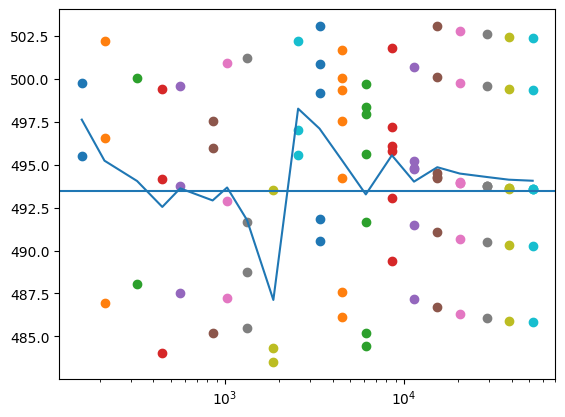

In [6]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Landscape), Evals_Landscape):
    ax.scatter([ndof] * len(evs), evs.real)
ax.set_xscale("log")
ax.plot(
    np.array(Ndofs_Landscape),
    np.array([np.real(np.mean(ev)) for ev in Evals_Landscape]),
)
ax.axhline(CENTER)  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

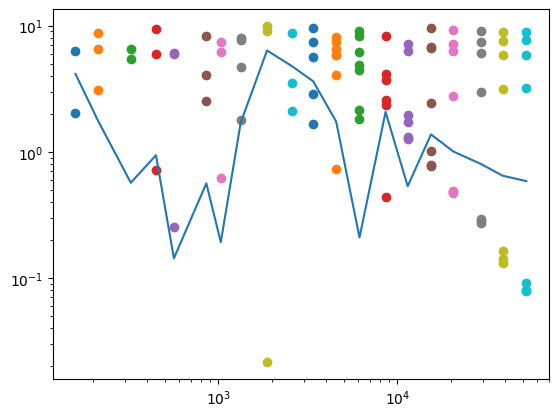

In [7]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Landscape), Evals_Landscape):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER))
ax.plot(np.array(Ndofs_Landscape), np.array(Error_Landscape))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

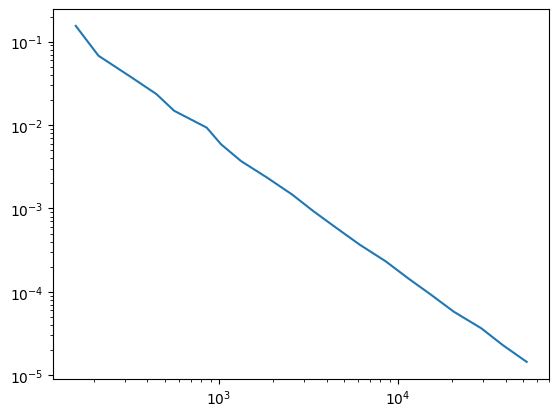

In [8]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.array(Ndofs_Landscape), np.array(Eta_Landscape))
# ax.plot(np.array(Ndofs_Landscape), np.array(EtaEV_Landscape))
plt.show()

## Eigenvalue-driven refinement (no filter)

In [9]:
mesh = reset_mesh()
fes = H1(mesh, order=ORDER, complex=IS_COMPLEX, dirichlet="boundary", autoupdate=True)

u, v = fes.TnT()

a = BilinearForm(fes)
a += grad(u) * grad(v) * dx

m = BilinearForm(fes)
m += u * v * dx

f = LinearForm(fes)
f += 1.0 * v * dx

assemble(a, m, f)

In [10]:
# Adaptivity parameters
MAX_ITER = 20
THETA = 0.5  # This works better with lower parameter, less focalized

iteration = 0
sol = GridFunction(fes, name="Landscape", autoupdate=True)

# Main loop

temp = []
while iteration < MAX_ITER:
    # Update
    assemble(a, m, f)
    iteration += 1
    # Solve
    sol.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
    # --- Init  call FEAST ---
    # Set clean eigenspace (required for adaptivity)
    right = NGvecs(fes, NSPAN)
    right.setrandom()
    left = NGvecs(fes, NSPAN)
    left.setrandom()
    # Set spectral projector
    projector = SpectralProjNG(
        fes,
        a.mat,
        m.mat,
        checks=CHECKS,
        radius=RADIUS,
        center=CENTER,
        npts=NPTS,
        verbose=False,
    )
    # Call FEAST
    # evalues, right, history, left = projector.feast(right, Yl=left, **feast_parameters)
    evalues, right, history, left = projector.feast(right, **feast_parameters)
    assert history[-1], "FEAST did not converge"
    # --- End  call  FEAST ---
    # ---  Estimate  ---
    eta_l, _ = error_estimator_landscape(sol)
    max_eta_l = max(eta_l)

    etas = []
    for i in range(right.m):
        eta, _ = error_estimator_ev(right.gridfun(i=i), evalues[i])
        etas.append(eta)
    etas = np.stack(etas, axis=0)
    eta_ev = np.max(etas, axis=1)
    max_eta_ev = max(eta_ev)
    # --- End Estimate ---
    # Mark
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta_ev > THETA * max_eta_ev
    # Store
    temp.append(eta_ev)
    Ndofs_Eigenmode.append(fes.ndof)
    Eta_Eigenmode.append(max_eta_l)
    EtaEV_Eigenmode.append(max_eta_ev)
    Evals_Eigenmode.append(evalues)
    Error_Eigenmode.append(np.abs(np.mean(evalues) - CENTER))
    # Refine
    if iteration == MAX_ITER:
        break
    mesh.Refine()
    del right, left, projector, history, evalues
    gc.collect()

Draw(sol, mesh, name="Landscape")
Draw(right.gridfun(i=None), mesh, name="evs")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

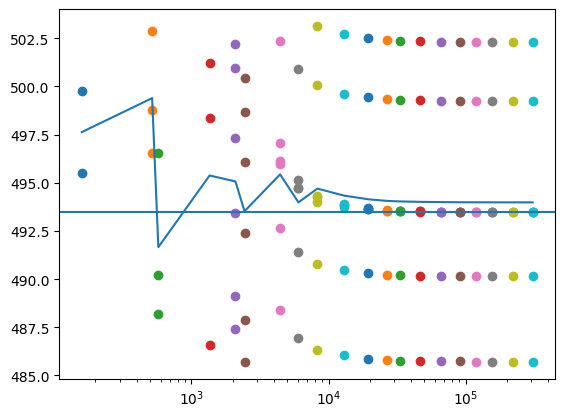

In [11]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Eigenmode), Evals_Eigenmode):
    ax.scatter([ndof] * len(evs), evs.real)
ax.set_xscale("log")
ax.plot(
    np.array(Ndofs_Eigenmode),
    np.array([np.real(np.mean(ev)) for ev in Evals_Eigenmode]),
)
ax.axhline(CENTER)  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

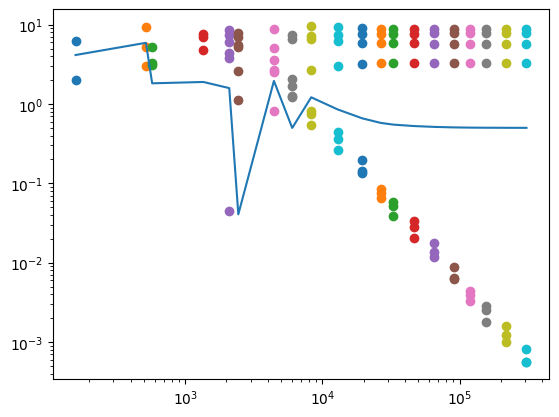

In [12]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Eigenmode), Evals_Eigenmode):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER))
ax.plot(np.array(Ndofs_Eigenmode), np.array(Error_Eigenmode))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

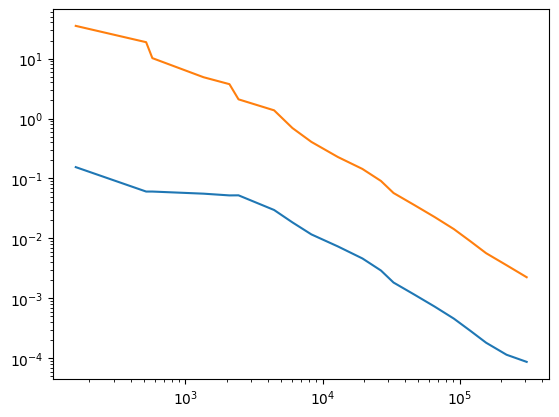

In [13]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.array(Ndofs_Eigenmode), np.array(Eta_Eigenmode))
ax.plot(np.array(Ndofs_Eigenmode), np.array(EtaEV_Eigenmode))
plt.show()

## Eigenvalue refinement (with filter and auxiliary landscape refinement)

In [ ]:
mesh = reset_mesh()
fes = H1(mesh, order=ORDER, complex=IS_COMPLEX, dirichlet="boundary", autoupdate=True)

u, v = fes.TnT()

a = BilinearForm(fes)
a += grad(u) * grad(v) * dx

m = BilinearForm(fes)
m += u * v * dx

f = LinearForm(fes)
f += 1.0 * v * dx

assemble(a, m, f)

In [ ]:
# Adaptivity parameters
MAX_ITER = 25
THETA = 0.5

iteration = 0
sol = GridFunction(fes, name="Landscape", autoupdate=True)

# Main loop
while iteration < MAX_ITER:
    # Update
    assemble(a, m, f)
    iteration += 1
    # Solve
    sol.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
    # --- Init  call FEAST ---
    # Set clean eigenspace (required for adaptivity)
    right = NGvecs(fes, NSPAN)
    right.setrandom()
    left = NGvecs(fes, NSPAN)
    left.setrandom()
    # Set spectral projector
    projector = SpectralProjNG(
        fes,
        a.mat,
        m.mat,
        checks=CHECKS,
        radius=RADIUS,
        center=CENTER,
        npts=NPTS,
        verbose=False,
    )
    # Call FEAST
    # evalues, right, history, left = projector.feast(right, Yl=left, **feast_parameters)
    evalues, right, history, _ = projector.feast(right, **feast_parameters)
    assert history[-1], "FEAST did not converge"
    # --- End  call  FEAST ---
    # Estimate
    eta_l, _ = error_estimator_landscape(sol)
    max_eta_l = max(eta_l)

    etas = []
    for i in range(right.m):
        if np.abs(evalues[i] - CENTER) < RADIUS:
            eta, _ = error_estimator_ev(right.gridfun(i=i), evalues[i])
            etas.append(eta)
    # Mark
    if not etas:
        print(f"Using landscape... Iteration {iteration}")
        mesh.ngmesh.Elements2D().NumPy()["refine"] = eta_l > THETA * max_eta_l
    else:
        etas = np.stack(etas, axis=0)
        eta_ev = np.max(etas, axis=0)
        max_eta_ev = max(eta_ev)
        mesh.ngmesh.Elements2D().NumPy()["refine"] = eta_ev > THETA * max_eta_ev
    # Store
    Ndofs_Eigenmode_Filter.append(fes.ndof)
    # Eta_Eigenmode_Filter.append(max_eta)
    # EtaEV_Eigenmode_Filter.append(max_eta_ev)
    Evals_Eigenmode_Filter.append(evalues)
    Error_Eigenmode_Filter.append(np.abs(np.mean(evalues) - CENTER))
    # Refine
    if iteration == MAX_ITER:
        break
    mesh.Refine()
    del right, left, projector, history, evalues
    gc.collect()

Draw(sol, mesh, name="Landscape")
Draw(right.gridfun(i=None), mesh, name="evs")

In [ ]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Eigenmode_Filter), Evals_Eigenmode_Filter):
    ax.scatter([ndof] * len(evs), evs.real)
ax.set_xscale("log")
ax.plot(
    np.array(Ndofs_Eigenmode_Filter),
    np.array([np.real(np.mean(ev)) for ev in Evals_Eigenmode_Filter]),
)
ax.axhline(CENTER)  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

In [ ]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Eigenmode_Filter), Evals_Eigenmode_Filter):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER))
ax.plot(np.array(Ndofs_Eigenmode_Filter), np.array(Error_Eigenmode_Filter))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

# Uniform refinements

In [ ]:
mesh = reset_mesh()
fes = H1(mesh, order=ORDER, complex=IS_COMPLEX, dirichlet="boundary", autoupdate=True)

u, v = fes.TnT()

a = BilinearForm(fes)
a += grad(u) * grad(v) * dx

m = BilinearForm(fes)
m += u * v * dx

f = LinearForm(fes)
f += 1.0 * v * dx

assemble(a, m, f)

In [ ]:
MAX_ITER = 7

iteration = 0
sol = GridFunction(fes, name="Landscape", autoupdate=True)

# Main loop
while iteration < MAX_ITER:
    # Update
    assemble(a, m, f)
    iteration += 1
    # Solve
    sol.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
    # --- Init  call FEAST ---
    # Set clean eigenspace (required for adaptivity)
    right = NGvecs(fes, NSPAN)
    right.setrandom()
    left = NGvecs(fes, NSPAN)
    left.setrandom()
    # Set spectral projector
    projector = SpectralProjNG(
        fes,
        a.mat,
        m.mat,
        checks=CHECKS,
        radius=RADIUS,
        center=CENTER,
        npts=NPTS,
        verbose=False,
    )
    # Call FEAST
    # evalues, right, history, left = projector.feast(right, Yl=left, **feast_parameters)
    evalues, right, history, _ = projector.feast(right, **feast_parameters)
    assert history[-1], "FEAST did not converge"
    # --- End  call  FEAST ---
    # Store
    Ndofs_Uniform.append(fes.ndof)
    Evals_Uniform.append(evalues)
    Error_Uniform.append(np.abs(np.mean(evalues) - CENTER))
    # Refine
    if iteration == MAX_ITER:
        break
    mesh.Refine()
    del right, left, projector, history, evalues
    gc.collect()

Draw(sol, mesh, name="Landscape")
Draw(right.gridfun(i=None), mesh, name="evs")

In [ ]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Uniform), Evals_Uniform):
    ax.scatter([ndof] * len(evs), evs.real)
ax.set_xscale("log")
ax.plot(
    np.array(Ndofs_Uniform), np.array([np.real(np.mean(ev)) for ev in Evals_Uniform])
)
ax.axhline(CENTER)  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

In [ ]:
fig, ax = plt.subplots()
for ndof, evs in zip(np.array(Ndofs_Uniform), Evals_Uniform):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER))
ax.plot(np.array(Ndofs_Uniform), np.array(Error_Uniform))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()